Imports

In [2]:
import sys

sys.path.insert(1, '../../src/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import pandas as pd

plt.style.use("../../thesis.mplstyle")

from matplotlib import patches
from scipy import ndimage

import solvers-legacy.rtm_solver as rtm
import solvers-legacy.minimal_solver as s

import utils.power_spectrum as util
import utils.power_spectrum as spectrum

Import Refractograms

In [33]:
factors = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.7,1.8,1.9,2.0,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0])
powers = [5,10]
pathName = '/rds/general/user/le322/home/synthPy/output/length_scale/5/'

shadow_5 = []
refract_5 = []
shadow_1 = []
shadow_10 = []
refract_10 = []
refract_1 = []

for factor in factors:
    fileName = pathName + str(factor)
    refract = pickle.load(open(f"{fileName}_refract.pkl", "rb"))
    shadow = pickle.load(open(f"{fileName}_shadow.pkl", "rb"))
    shadow_5.append(shadow)
    refract_5.append(refract)

pathName = '/rds/general/user/le322/home/synthPy/output/length_scale/10/'

for factor in factors:
    fileName = pathName + str(factor)
    refract = pickle.load(open(f"{fileName}_refract.pkl", "rb"))
    shadow = pickle.load(open(f"{fileName}_shadow.pkl", "rb"))
    shadow_10.append(shadow)
    refract_10.append(refract)

pathName = '/rds/general/user/le322/home/synthPy/output/length_scale/1/'

for factor in factors[factors < 1.5]:
    fileName = pathName + str(factor)
    refract = pickle.load(open(f"{fileName}_refract.pkl", "rb"))
    shadow = pickle.load(open(f"{fileName}_shadow.pkl", "rb"))
    shadow_1.append(shadow)
    refract_1.append(refract)


In [64]:

from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2, 1],[0,-1,-2], shape=(L, L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def clean(sig):
    baseline          =   baseline_als_optimized(sig, 4e10, 1e-3)
    sig_corr        =   (sig - baseline ) / baseline

    sig_norm       =   (sig_corr - sig_corr.min()) / (sig_corr.max() + sig_corr.min())

    return sig_norm

def total(arr):
    totals = []
    for i, r1 in enumerate(arr):
        totalSum = np.zeros(r1.shape[0])
        for j in range(len(r1[:,0]) - 1):
            totalSum[j] += np.sum((r1[j,:])) # maybe clean here tho

        totals.append(clean(totalSum))

    print(len(totals))

    return totals

r_5 = total(refract_5)
r_10 = total(refract_10)
r_1 = total(refract_1)


34
34
12


In [65]:
from lmfit.models import GaussianModel, ConstantModel

c1 = '#1C6758'   # dark green
c2 = '#006e23'   # ciano
c3 = '#6e0052'   # violet
c4 = '#db4900'   # purple
c5 = '#37e67d'   #light green

def plot_grams(totals):
    fig, axes = plt.subplots(4,9, figsize = (40,30))
    ax = axes.flatten()
    stds = []
    uncs = []
    x = np.linspace(-35,35, len(totals[0]))
    for i, total in enumerate(totals):
        # ax1.plot(x, total1, lw=1.5, alpha = 15 / 15, zorder=2)
        # ax2.plot(x, total2, lw=1.5, alpha = 15 / 15, zorder=2)

        mod               =   GaussianModel() + ConstantModel()
        mod.make_params()
        mod.set_param_hint('sigma', value=10)
        mod.set_param_hint('amplitude', value=1)
        res1 = mod.fit(total, x = x, nan_policy='omit')

        ax[i].plot(x, res1.best_fit, color='red', linewidth=4.0, zorder = 4)


        nstd     = 8 # to draw 5-sigma intervals
        error_up = res1.best_fit + nstd * res1.eval_uncertainty()
        error_dw = res1.best_fit - nstd * res1.eval_uncertainty()

        ax[i].fill_between(x, 
                        error_up,
                        error_dw, 
                        color='red', alpha=1,  edgecolor='b', lw = 0)

        ax[i].fill_between(x, total, facecolor = c4, alpha=0.5, zorder = 2, lw = 0.1)



        sigma1 = res1.best_values['sigma']
        unc1 = res1.params['sigma'].stderr

        uncs.append(unc1)
        stds.append(sigma1)
    index = len(totals)
    for i, a in enumerate(ax[0:index]):
    #     a.grid()
        a.set_xlabel(r'Fourier Axis, $\phi$ [mrad]',fontsize = 18)
        a.set_title(f'{factors[i]*10} mm, , $\sigma$ = {np.round(stds[i],3 )}')
        a.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()

    return fig, stds, uncs
    

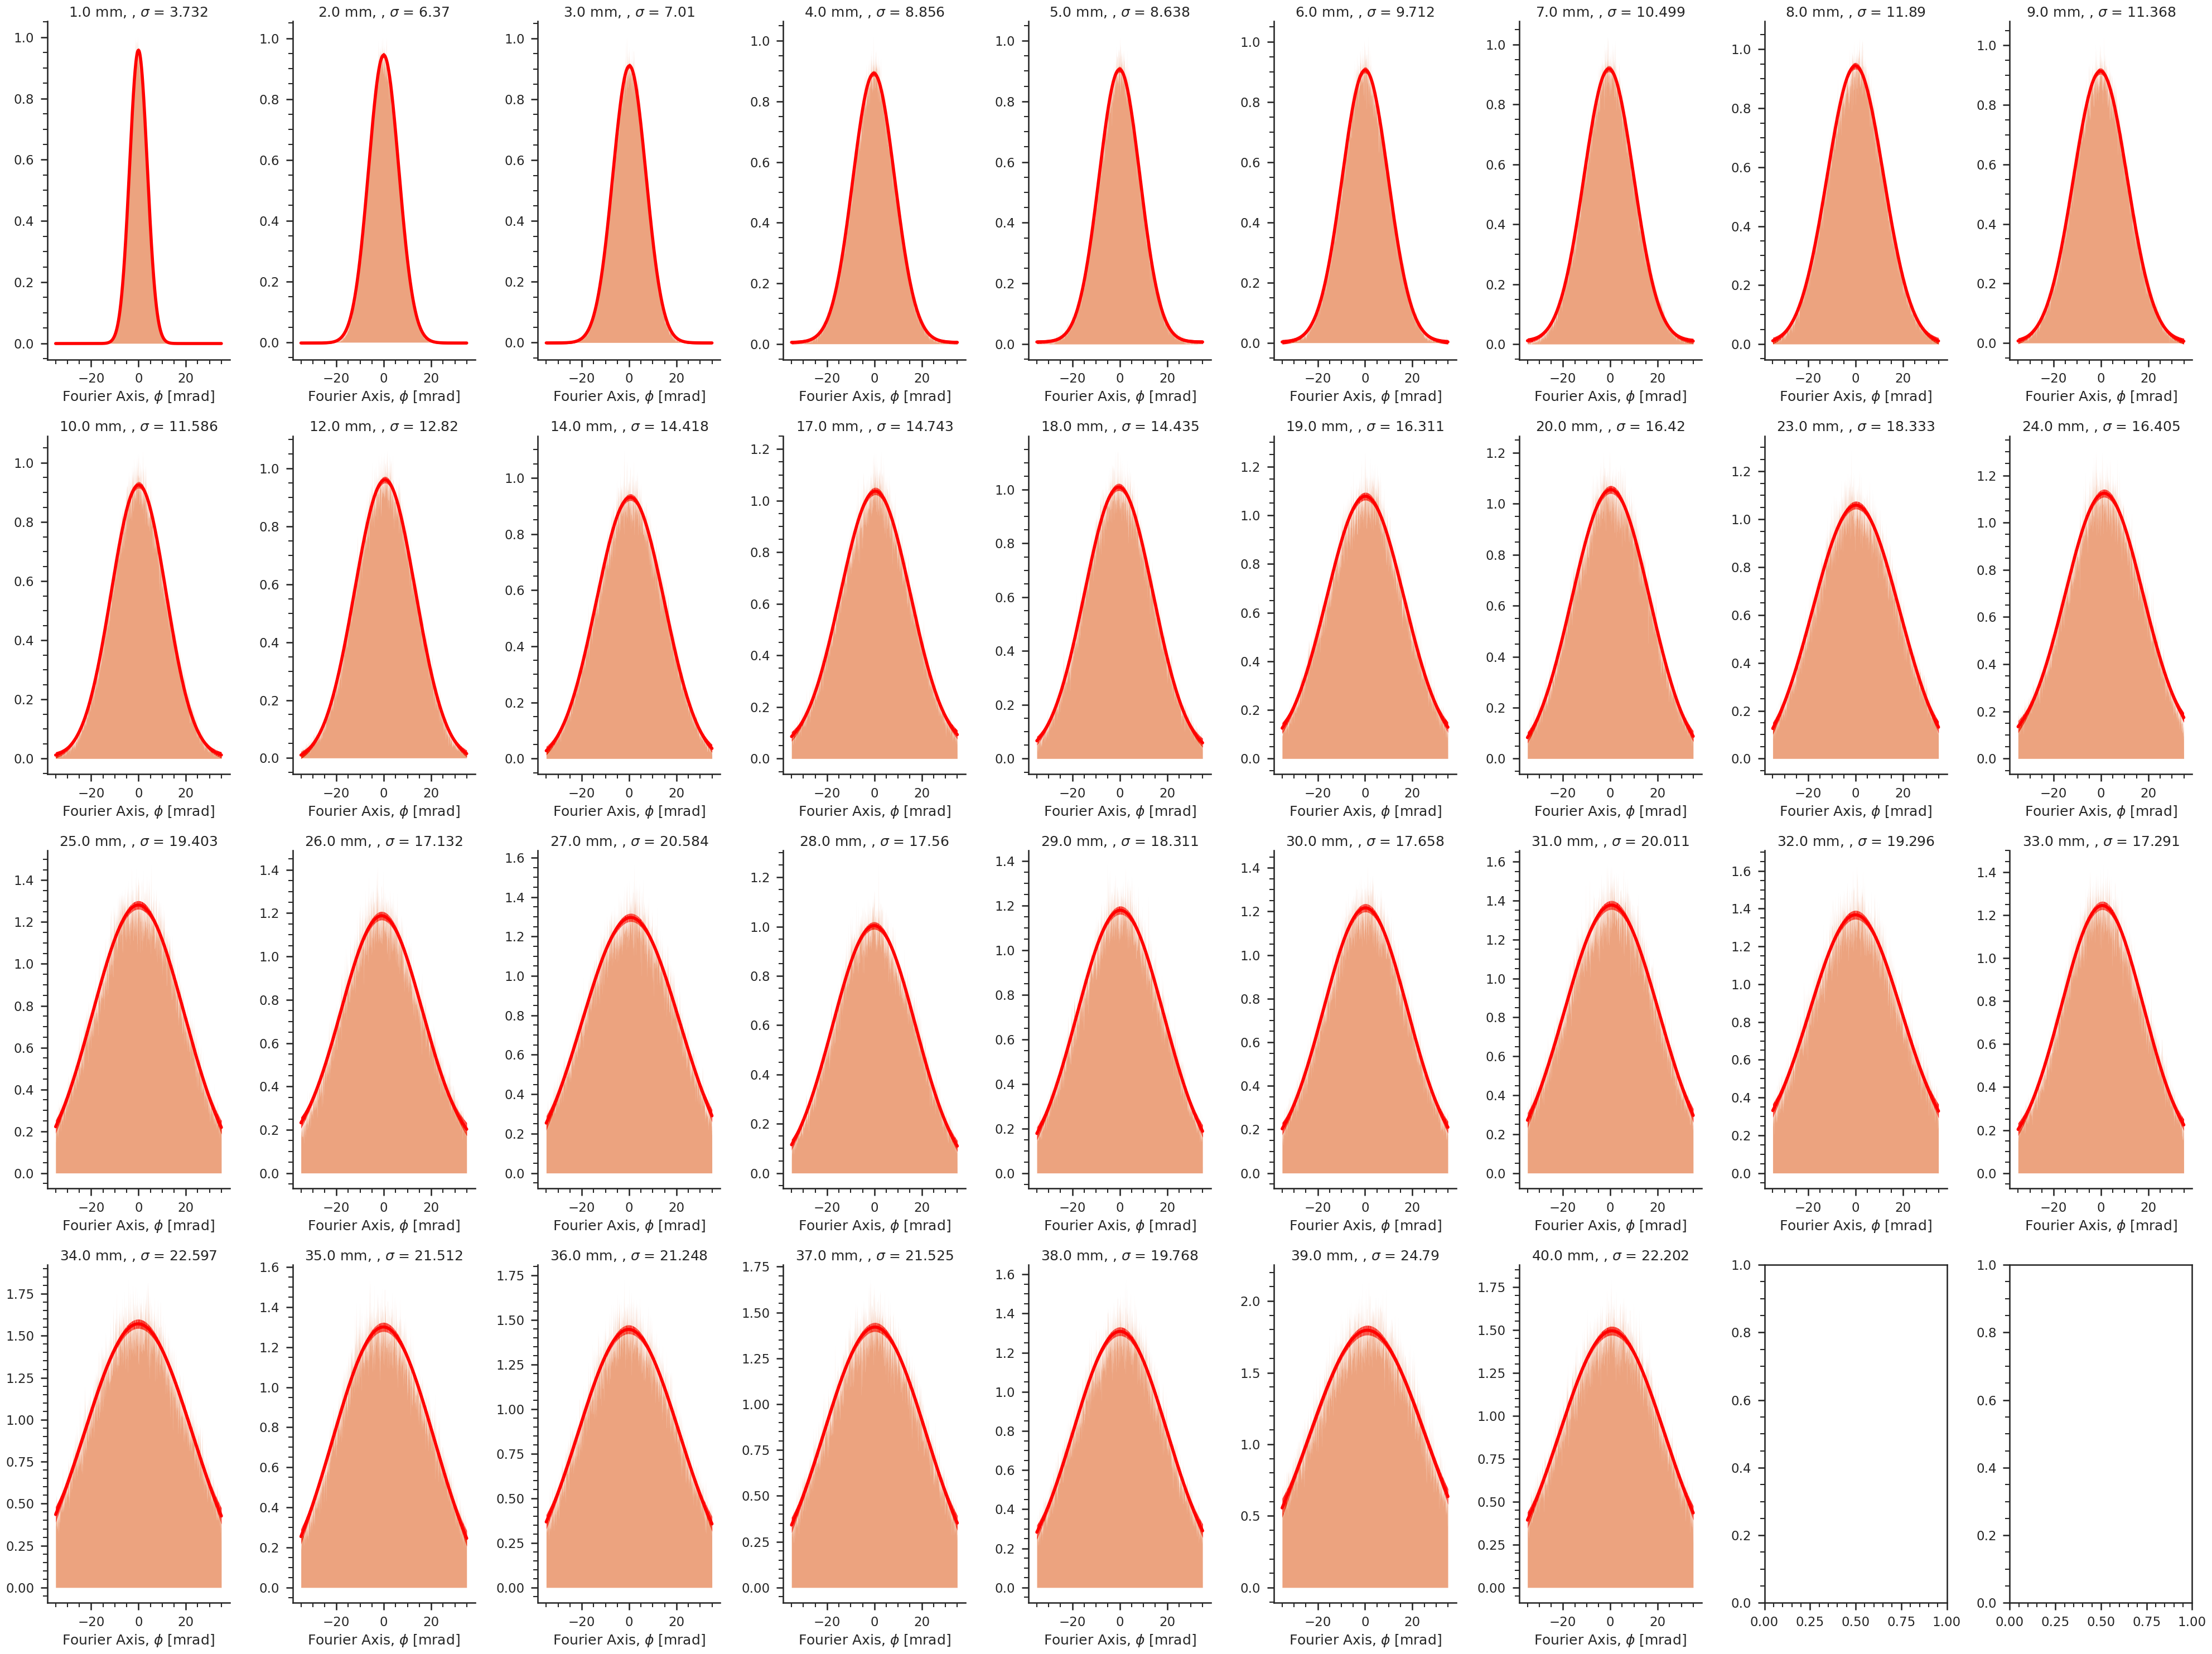

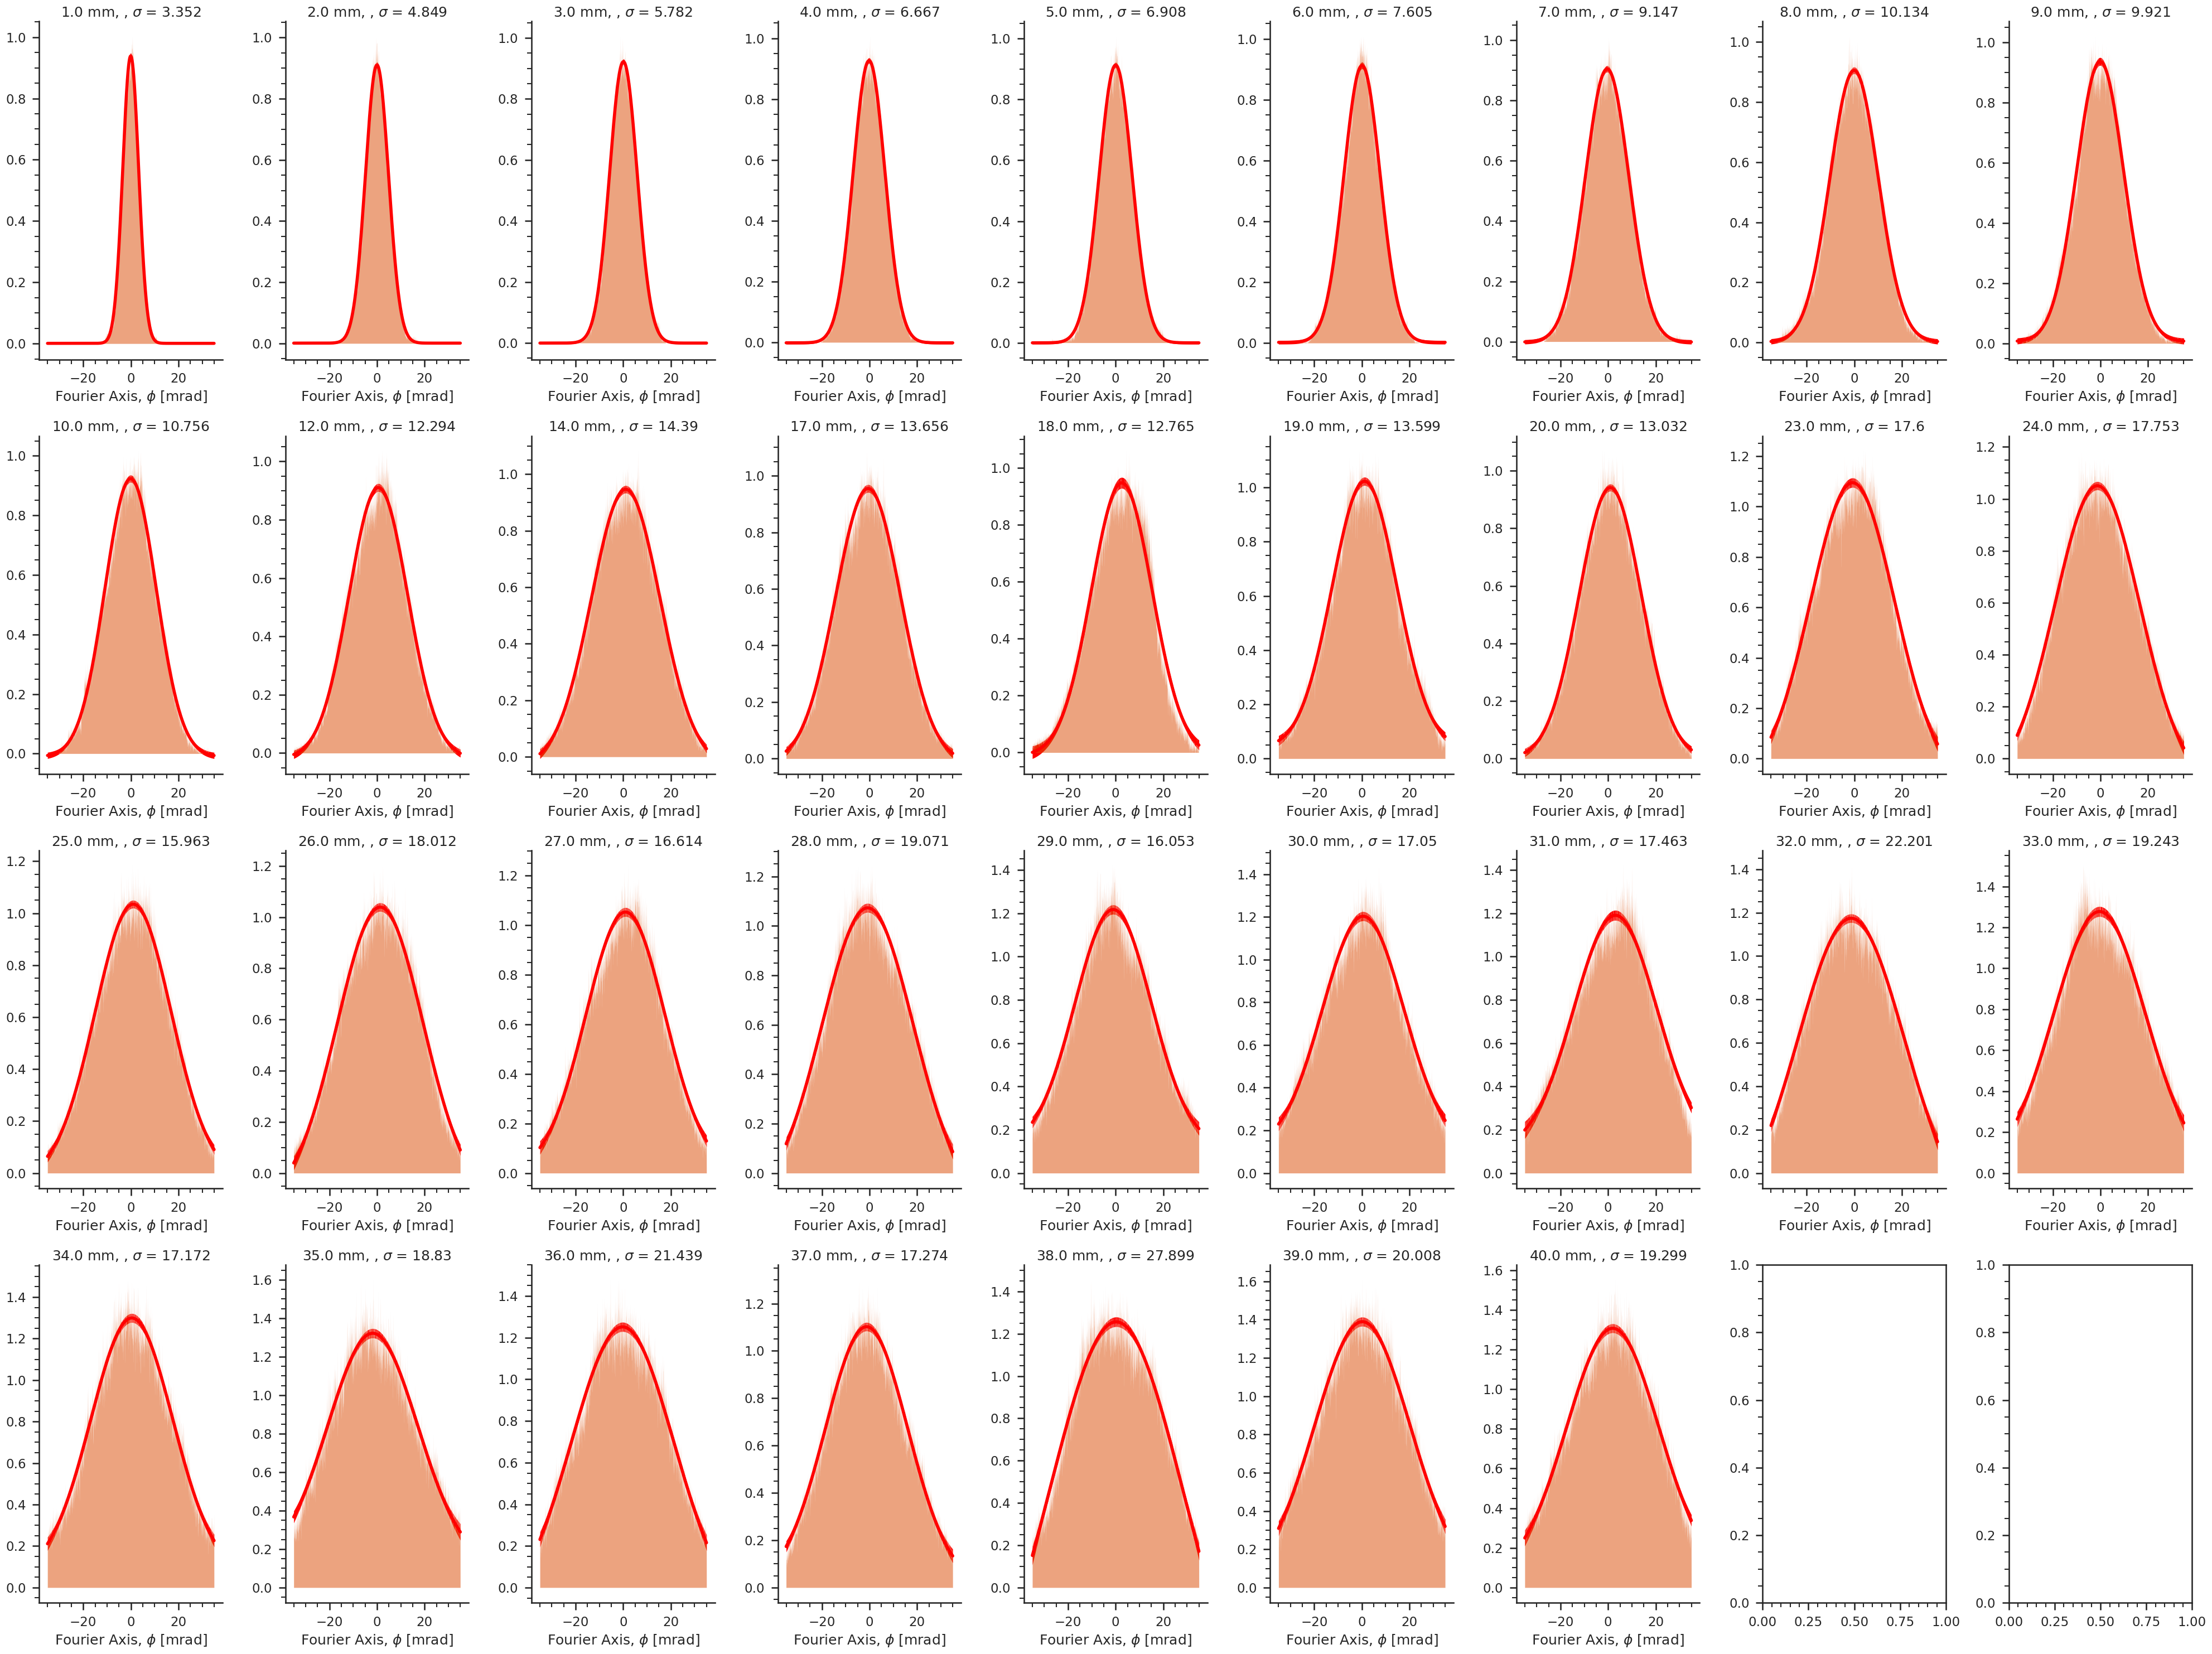

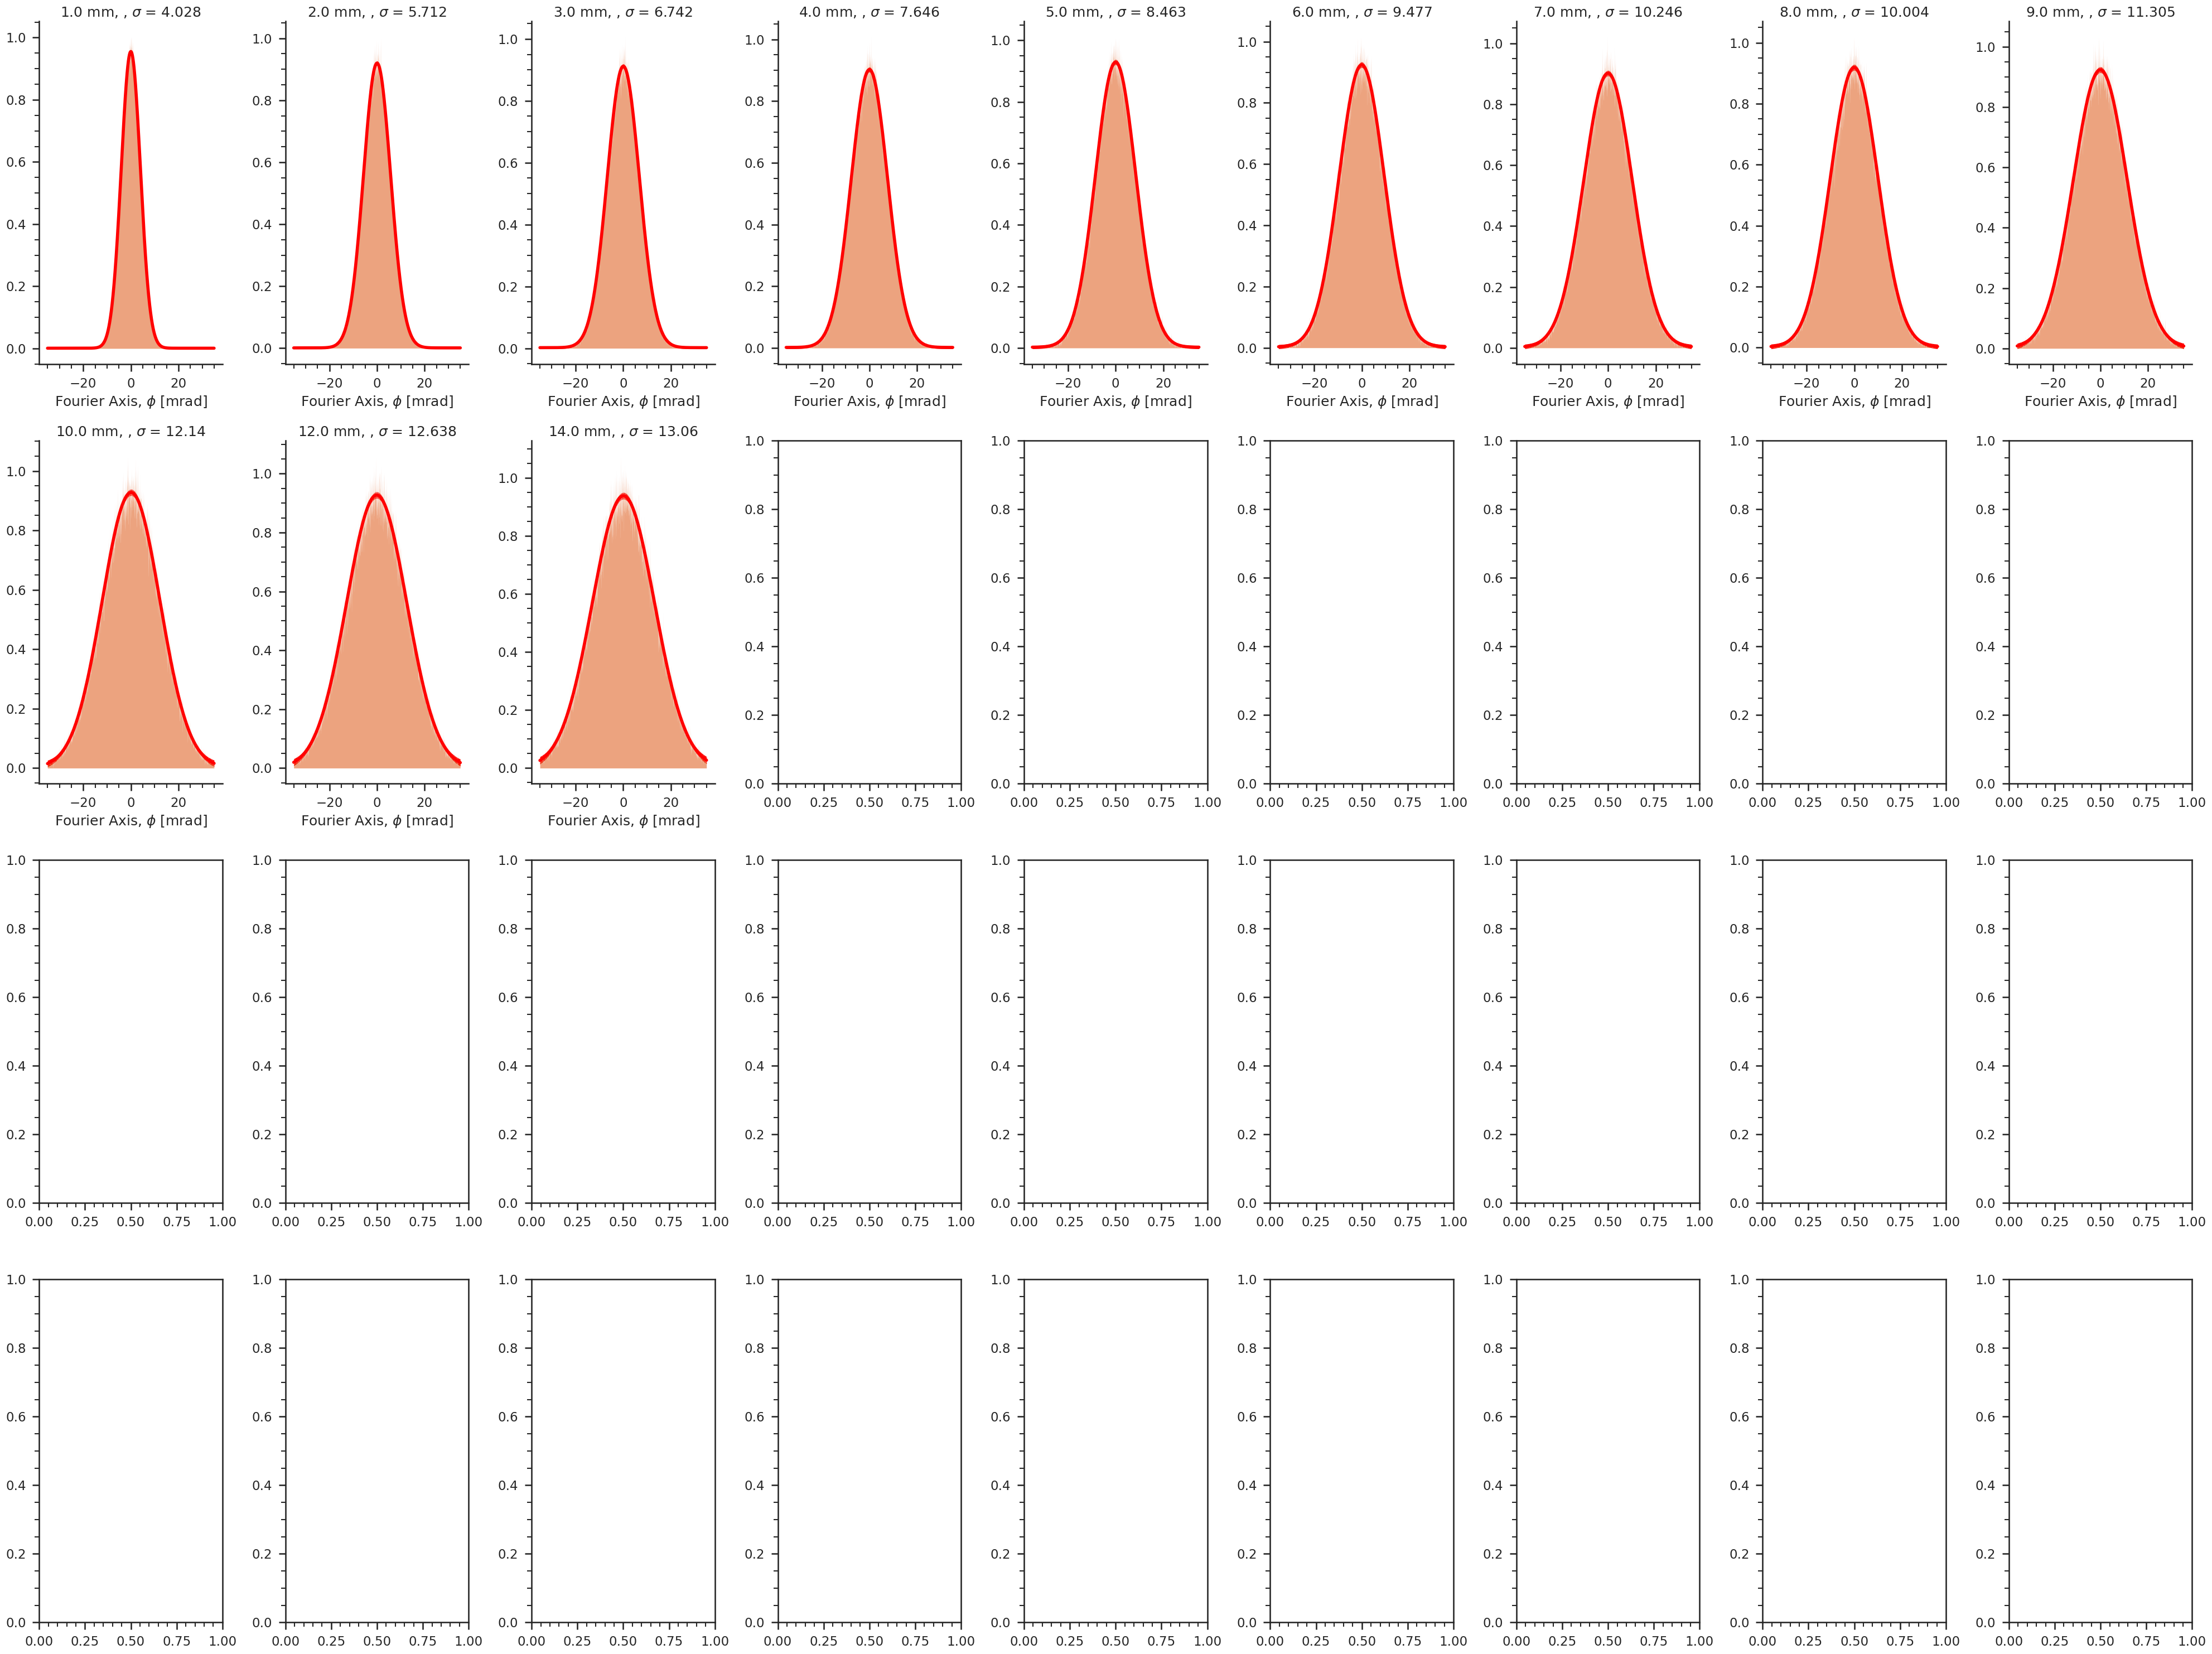

In [66]:
fig_5, sigma_5, unc_5 = plot_grams(r_5)

fig_10, sigma_10, unc_10 = plot_grams(r_10)

fig_1, sigma_1, unc_1 = plot_grams(r_1)



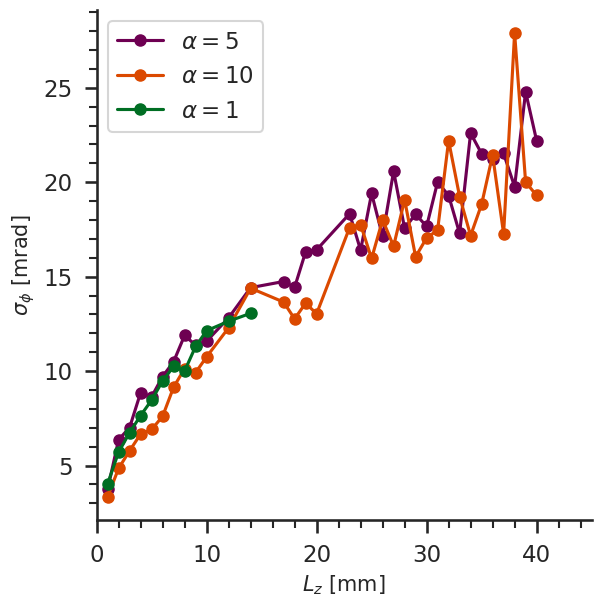

In [67]:
import seaborn as sns
from matplotlib import patches

def find_lz(sigma, epsilon = 1):
    ne = 1e25
    sigma = np.array(sigma)
    # L_z = extents
    lwl = 1053e-9
    c = 3e8
    omega = 2*np.pi*(c/lwl)
    nc = 3.142e-4 * omega**2
    
    sigma *= 1e-3

    return ((ne**2)/(4*nc**2*sigma**2))

sigma5 = np.array(sigma_5)
sigma10 = np.array(sigma_10)
sigma1 = np.array(sigma_1)

unc5 = np.array(unc_5)
unc10 = np.array(unc_10)
unc1 = np.array(unc_1)



sns.set(style="ticks", context="talk")
# plt.style.use("white")
lengths = factors*10
fig, ax = plt.subplots(figsize = (6,6))
# ax.plot(lengths[2:], l_15[2:], '-o', markersize = 8, color = c2, label = '1.5')
ax.plot(lengths, sigma5, '-o', markersize = 8, color = c3, label = r'$\alpha = 5$')
ax.plot(lengths, sigma10, '-o', markersize = 8, color = c4, label = r'$\alpha = 10$')
ax.plot(lengths[0:len(sigma1)], sigma1, '-o', markersize = 8, color = c2, label = r'$\alpha = 1$')

# ax.errorbar(lengths, sigma5, yerr = 2*unc5, fmt = 'x',markersize = 0, color = c3, zorder = 0)
# ax.errorbar(lengths, sigma10, yerr = 2*unc10, fmt = 'x',markersize = 0, color = c4, zorder = 0)
# ax.errorbar(lengths[0:len(sigma1)], sigma1, yerr = 2*unc1, fmt = 'x',markersize = 0, color = c2, zorder = 0)





# plt.hlines([1.5, 2.5, 3.5], 0, 20, zorder = 1, ls= ':', color = [c2,c3,c4], lw = 2.5, alpha = 0.8)
# plt.plot(np.log)
# plt.grid()
ax.set_ylabel(r'$\sigma_{\phi}$ [mrad]', fontsize = 15)
ax.set_xlabel(r'$L_z$ [mm]', fontsize = 15)

ax.spines[['right', 'top']].set_visible(False)

# ax.set_ylim(0, 5)
ax.set_xlim(0, 45)
# plt.plot(lengths, stds[1:], 'x')
# ax.tick_params(axis = 'both', which = 'major', labelsize = 15, width = 1, size = 5)
# ax.set_xticks([2, 4, 6, 8,10,12,14, 16,18,20])
# ax.annotate('$\delta_{max}$ = 3.5 mm', (21, 4.2), fontsize = 15, color = c4)
# ax.annotate('$\delta_{max}$ = 1.5 mm', (21, 2.5), fontsize = 15, color = c2)
# for axis in ['top', 'bottom']:
#     ax.spines[axis].set_linewidth(1.5)
# con = patches.ConnectionPatch((2, 0.1), (2, 2.5), coordsA = 'data', coordsB = 'data', arrowstyle = "<->", shrinkA = 5, shrinkB = 5, mutation_scale = 10, lw = 2, color = 'white', zorder = 5)
# ax.add_artist(con)
# ax.annotate(r'Imposed Scale Range', (1.9, 0.75), rotation = 90, fontsize = 12, weight = 'bold')
plt.legend()

plt.show()